# Task 2: Coordinate Transformations

In this notebook we will use what we have learned about marker detection in the last notebook

## Imports

In [1]:
# imports
import cv2
from matplotlib import pyplot as plt
import numpy as np
import yaml
import io

## Setup

We again load the camera parameters. This time not only need them for preprocessing our image, but we will also use them when estimating where the markers are relative to the camera.

In [2]:
# load camera parameters
with open("../camera_intrinsics.yml", 'r') as stream:
    camera_intrinsics = yaml.safe_load(stream)
camera_matrix = np.array(camera_intrinsics["camera_matrix"]["data"]).reshape((3,3))
distortion_coefficients = np.array(camera_intrinsics["distortion_coefficients"]["data"])

The other component for estimating the markers' poses and postions we need to know beforehand, is the size of our markers.

In [3]:
# set marker size
marker_size = 0.05

## Detect Aruco Markers

**Task:** Undistort the image and detect the Aruco markers within it. Use the *cv2.aruco.DICT_ARUCO_ORIGINAL* dictionary for detection. 

**Note:** You don't have to undistort the image after loading it, because the function that handles the marker pose estimation will do that internally.

**Note:** The list that contains the marker ids should be named *ids*, in order for the provided code to run without changes.

[[650]
 [863]
 [548]
 [860]]


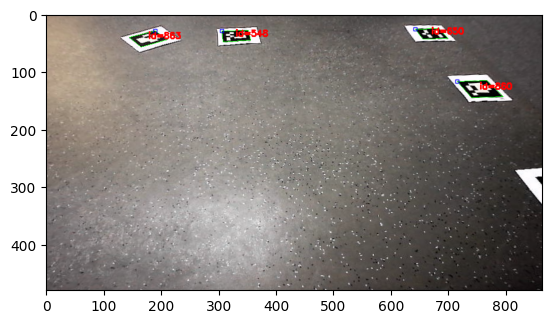

In [4]:
# load image
img = cv2.imread("./2024-09-12_17-29-34/img_282.jpg")
img_undistorted = img.copy()
### Your code here ###
img_undistorted = cv2.undistort(img, camera_matrix, distortion_coefficients)
# setup detector

arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_ARUCO_ORIGINAL)
arucoParams = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(arucoDict, arucoParams)
markerCorners, markerIds, rejectedCandidates = detector.detectMarkers(img_undistorted)
# detect markers in the image
corners, ids, rejectedCandidates = detector.detectMarkers(img_undistorted)
print(ids)
# draw markers onto the image

img_with_markers = img_undistorted.copy()
cv2.aruco.drawDetectedMarkers(img_with_markers, markerCorners, markerIds)
###


plt.imshow(img_with_markers)

In [5]:
ids

array([[650],
       [863],
       [548],
       [860]], dtype=int32)

## Pose Estimation

**Task:** Use OpenCV's *solvePnP* function to estimate the poses of the markers detected in the previous task. 

In [6]:
# estimate marker poses using the detected marker corners from the image, the camera parameters, and the (known) size of the marker 


marker_rvecs = []
marker_tvecs = []

# marker corners
marker_points = np.array([[-marker_size / 2, marker_size / 2, 0],
                          [marker_size / 2, marker_size / 2, 0],
                          [marker_size / 2, -marker_size / 2, 0],
                          [-marker_size / 2, -marker_size / 2, 0]])

### Your code here ###


for i, corners in enumerate(markerCorners):
    imagePoints = corners.reshape(-1,2)
    
    success, rvec, tvec = cv2.solvePnP(marker_points, imagePoints,camera_matrix,distortion_coefficients)
    print(rvec)
    if success:
        marker_rvecs.append(rvec)
        marker_tvecs.append(tvec)

###

[[ 2.28498564]
 [-0.07473484]
 [-0.14614792]]
[[ 2.07299732]
 [ 0.94419168]
 [-0.19395079]]
[[ 2.31324765]
 [-0.20621605]
 [ 0.22105348]]
[[ 2.19174839]
 [-0.08684035]
 [-0.10075559]]


**Task:** Use OpenCV's *drawFrameAxes* function to visualise the estimated marker poses.

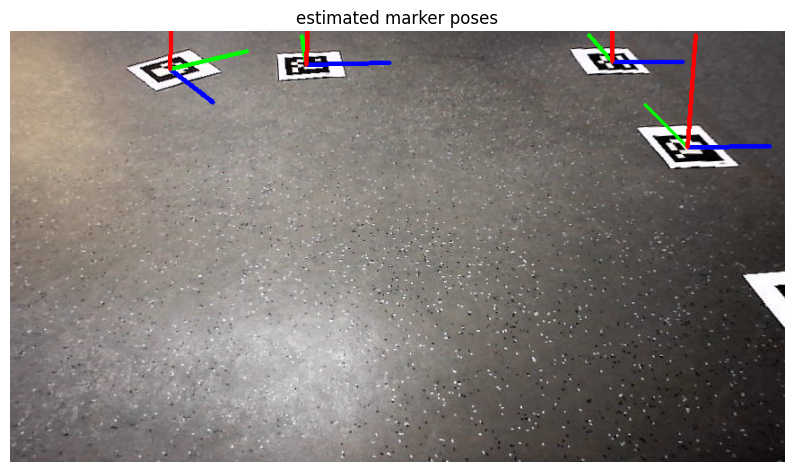

In [7]:
# visualise the estimated marker poses in the image
img_axis = img_undistorted.copy()
### Your code here ###

for rvec,tvec in zip(marker_rvecs,marker_tvecs):
    cv2.drawFrameAxes(img_axis,camera_matrix,distortion_coefficients,rvec,tvec,marker_size*2)
plt.figure(figsize=(10,10))
plt.imshow(img_axis)
plt.title("estimated marker poses")
plt.axis("off")
plt.show()

## Projecting Aruco Marker Positions to Robot and World Frame

In [8]:
def rotation_matrix(x_rotation, y_rotation, z_rotation):
    alpha = z_rotation
    beta = y_rotation
    gamma = x_rotation

    # https://en.wikipedia.org/wiki/Rotation_matrix
    # rotates around z, then y, then x

    return np.array([
        [np.cos(alpha)*np.cos(beta), np.cos(alpha)*np.sin(beta)*np.sin(gamma)-np.sin(alpha)*np.cos(gamma), np.cos(alpha)*np.sin(beta)*np.cos(gamma)+np.sin(alpha)*np.sin(gamma)],
        [np.sin(alpha)*np.cos(beta), np.sin(alpha)*np.sin(beta)*np.sin(gamma)+np.cos(alpha)*np.cos(gamma), np.sin(alpha)*np.sin(beta)*np.cos(gamma)-np.cos(alpha)*np.sin(gamma)],
        [-np.sin(beta), np.cos(beta)*np.sin(gamma), np.cos(beta)*np.cos(gamma)]
    ])

In [9]:
def vectors_to_transformation_matrix(rotation, translation):
    ### Your code here ###
    T = np.eye(4)
    T[:3,:3] = rotation
    T[:3,3] = translation
    
    ###
    return T

In [10]:
def transformation_matrix_to_vectors(t):
    ### Your code here ###
    x_rotation = t[:3,0]
    y_rotation = t[:3,1]
    z_rotation = t[:3,2]
    translation = t[:3,3]
    
    ###
    return np.array([x_rotation, y_rotation, z_rotation]), translation

### Projecting to robot frame

In [11]:
# offset from camera to robot frame
x_offset_camera = 0.03
y_offset_camera = 0
z_offset_camera = 0.28

offset_camera_robot = np.array([x_offset_camera,y_offset_camera,z_offset_camera]) 

In [12]:
# angle from camera to robot frame
x_angle_camera = -140 #degrees
y_angle_camera = 0
z_angle_camera = -90 #degrees

rotation_camera_robot = np.array([np.radians(x_angle_camera), np.radians(y_angle_camera), np.radians(z_angle_camera)])

**Task:** Create transform matrix from camera frame to robot frame.

In [13]:
### Your code here ###
rotation_mat = rotation_matrix(rotation_camera_robot[0],rotation_camera_robot[1],rotation_camera_robot[2])
translation_vector = offset_camera_robot
T_camera_robot = vectors_to_transformation_matrix(rotation=rotation_mat,translation=translation_vector)


###

**Task:** Create transform matrices for all markers, project them into the robot coordinate frame, and transform the resulting matrices back into rotation and translation vectors. Also print the id and world position for each marker.

In [14]:
# create transform matrices for all markers, project them into the robot coordinate frame
# transform them to rotation and translation vectors
marker_rvecs_robot = []
marker_tvecs_robot = []
### Your code here ###

for rvec, tvec in zip(marker_rvecs, marker_tvecs):
    # Rodrigues is used to represent the rotation vector as a matrix that inherits the rotation with respect to the axis (x,y,z) based on the calculated vector above.
    rotation_mat_marker, _ = cv2.Rodrigues(rvec)
    
    transformation_marker_camera = vectors_to_transformation_matrix(rotation_mat_marker, np.array(tvec).flatten())
    
    transformation_marker_robot = T_camera_robot @ transformation_marker_camera
    rvec_robot, tvec_robot = transformation_matrix_to_vectors(transformation_marker_robot)
    marker_rvecs_robot.append(rvec_robot)
    marker_tvecs_robot.append(tvec_robot)
###
print(marker_tvecs_robot)

[array([ 0.60140527, -0.24088136, -0.03292537]), array([0.52974321, 0.25237215, 0.0007925 ]), array([ 0.61536716,  0.11981129, -0.05667146]), array([ 0.37683733, -0.2358423 ,  0.0161009 ])]


Now, let us visualise the results of our pose estimation. We start with a visualisation of where the detected markers are, realitve to our robot, on the vertical plane. 

Text(0.5, 1.0, 'vertical plane')

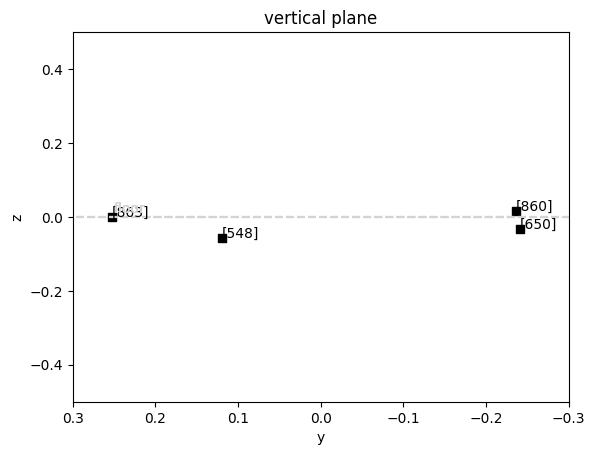

In [15]:
for i, c in enumerate(marker_tvecs_robot):
    id = ids[i]
    plt.scatter([c[1]], [c[2]], color="black", marker="s")
    plt.text(c[1], c[2], str(id))
    plt.ylabel("z")
    plt.xlabel("y")
    plt.xlim([-0.3, 0.3])
    plt.ylim([-0.5, 0.5])
    plt.axhline(0,-1,1, color="lightgray", ls="--")
    plt.text(0.25, 0.01, "floor", color="lightgray")

plt.gca().invert_xaxis()
plt.title("vertical plane")

We can see that, although all markers in the image are obviously placed directly on the floor, our estimated positions don't line uo perfectly with it. Some markers are estimated to "float" a bit above the floor, some are estimated to be slightly below it. This kind of imperfect measurement is something we must always expect when working with imperfect data. In our example, our camera calibration might not be completely optimal our images might be noisy, etc. Overall, however, these results aren't too bad and definitely still usable for our purposes. 

Next, we visualise where the markers are on the horizontal plane (i.e. the floor), relative to our robot. Because the robot is the reference point, it will always be at position (0,0).

Text(0.5, 1.0, 'horizontal plane')

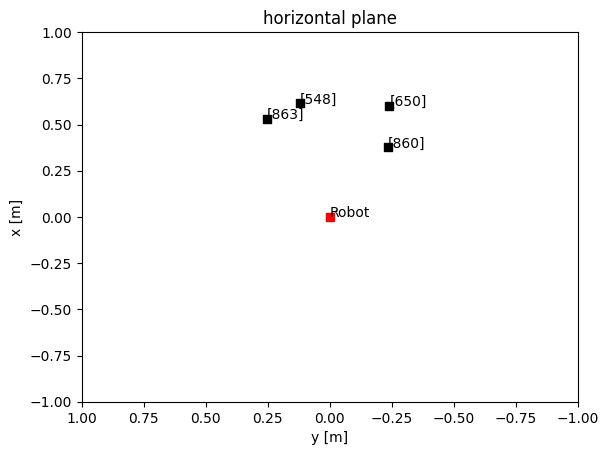

In [16]:
for i, c in enumerate(marker_tvecs_robot):
    id = ids[i]
    plt.scatter([c[1]], [c[0]], color="black", marker="s")
    plt.text(c[1], c[0], str(id))
    plt.ylabel("x [m]")
    plt.xlabel("y [m]")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.scatter([0], [0], color="red", marker="s")
plt.text(0, 0, "Robot")
plt.gca().invert_xaxis()
plt.title("horizontal plane")

### Projecting to world frame

Now that we know, where the markers are relative to our robot, we want to determine, where they are in our world coordinate frame. We will later need this to, for example, implement the landmark detection and localisation, as well as the SLAM algorithm for our robot.  
Let's assume that our robot started at the origin of the world coordinate frame. Now it has moved 40cm forwards and 25cm to the left, with a current heading o 30° to the right.


In [17]:
# offset from robot to world frame
x_offset_world = 0.4
y_offset_world = 0.25
z_offset_world = 0

# angle from robot to world frame
x_angle_world = 0 #degrees
y_angle_world = 0
z_angle_world = -30

offset_robot_world = np.array([x_offset_world,y_offset_world,z_offset_world]) 
rotation_robot_world = np.array([np.radians(x_angle_world), np.radians(y_angle_world), np.radians(z_angle_world)])

**Task:** Create transform matrix from robot to world frame.

In [18]:
### Your code here ###
rotation_mat_robot_world = rotation_matrix(rotation_robot_world[0],rotation_robot_world[1],rotation_robot_world[2])
translation_vector_robot_world = offset_robot_world
T_robot_world = vectors_to_transformation_matrix(rotation=rotation_mat_robot_world,translation=translation_vector_robot_world)
###

**Task:** Create transform matrices for all markers in the robot coordinate frame, project them into the world coordinate frame, and transform them to rotation and translation vectors. Also print the id and world position for each marker.

In [19]:
marker_rvecs_world = []
marker_tvecs_world = []
### Your code here ###
for i, (rvec, tvec) in enumerate(zip(marker_rvecs,marker_tvecs)):
   
    rotation_matrix_marker, _ = cv2.Rodrigues(rvec)
   
    T_marker_camera = vectors_to_transformation_matrix(rotation_matrix_marker, np.array(tvec).flatten())
   
    T_marker_robot = T_camera_robot @ T_marker_camera
   
    T_marker_world = T_robot_world @ T_marker_robot

    rvec_world, tvec_world = transformation_matrix_to_vectors(T_marker_world)
    print(tvec_world)
    marker_rvecs_world.append(rvec_world)
    marker_tvecs_world.append(tvec_world)
    
    # Print marker ID and world position
    print(f"Marker ID: {ids[i]}")
    #print(f"World Position (Translation Vector): {tvec_world.flatten()}")
    #print(f"Rotation Vector in World Frame: {rvec_world.flatten()}")
    #print("-" * 50)
   
###
print(marker_tvecs_world)
print(marker_rvecs_world)

[ 0.80039156 -0.25931202 -0.03292537]
Marker ID: [650]
[9.84957157e-01 2.03689090e-01 7.92496917e-04]
Marker ID: [863]
[ 0.99282924  0.04607604 -0.05667146]
Marker ID: [548]
[ 0.60842955 -0.14266409  0.0161009 ]
Marker ID: [860]
[array([ 0.80039156, -0.25931202, -0.03292537]), array([9.84957157e-01, 2.03689090e-01, 7.92496917e-04]), array([ 0.99282924,  0.04607604, -0.05667146]), array([ 0.60842955, -0.14266409,  0.0161009 ])]
[array([[-0.47323014, -0.87164315,  0.12763796],
       [ 0.85865743, -0.48877412, -0.15429611],
       [ 0.19687728,  0.03657971,  0.97974551]]), array([[-0.96619278, -0.25696095, -0.0210378 ],
       [ 0.25438867, -0.93688219, -0.23987115],
       [ 0.04192758, -0.23711356,  0.97057676]]), array([[-0.30897445, -0.94353684, -0.11946974],
       [ 0.94905438, -0.29770274, -0.10329016],
       [ 0.06189161, -0.1452973 ,  0.98745031]]), array([[-0.45345276, -0.88618295,  0.09518596],
       [ 0.85140537, -0.4622751 , -0.24781167],
       [ 0.26360858, -0.03132905, 

Let's now again visualise our results. First, we plot where our markers are relative to the floor.  

Text(0.5, 1.0, 'vertical plane')

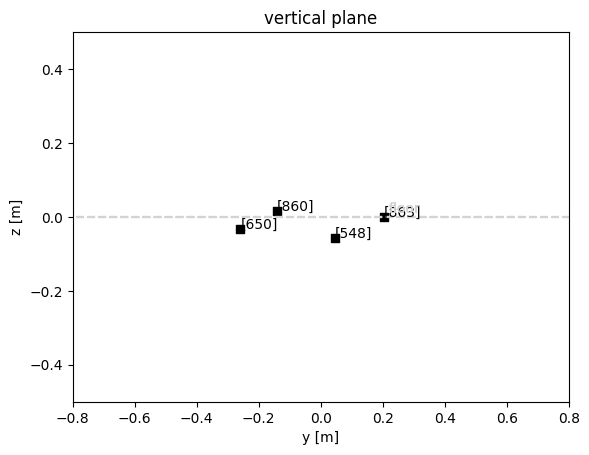

In [20]:
for i, c in enumerate(marker_tvecs_world):
    id = ids[i]
    # we mirror the y coordinate, because in the robot coordinate system y < 0 indicates a position to the right of the 
    # robot, but in the pyplot visualisation values < 0 are displayed on the left. The x ticks are adjusted accordingly.
    plt.scatter([c[1]], [c[2]], color="black", marker="s")
    plt.text(c[1], c[2], str(id))
    plt.ylabel("z [m]")
    plt.xlabel("y [m]")
    plt.xlim([-0.8, 0.8])
    plt.ylim([-0.5, 0.5])
    plt.axhline(0,-1,1, color="lightgray", ls="--")
    plt.text(0.22, 0.01, "floor", color="lightgray")
   
plt.title("vertical plane")

The measurement error from the previous pose estimation step obviously still exists, but overall our measurement is still good enough to use it, for example for navigation.

Finally, we again visualise the positions of the markers in the horizontal plane. This time we also visualise the position of our robot. This gives us essentially a section of our world map.

Text(0.5, 1.0, 'horizontal plane')

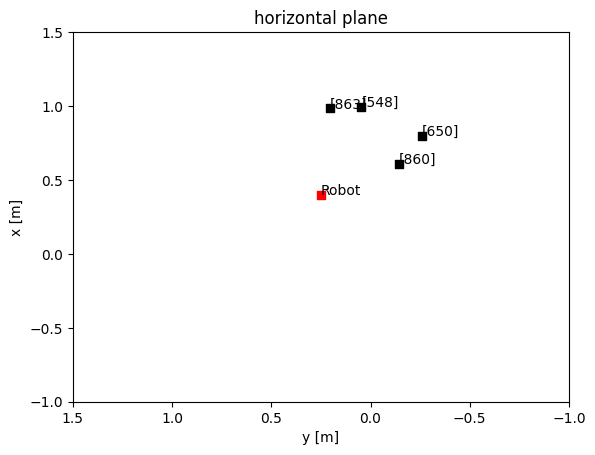

In [21]:
for i, c in enumerate(marker_tvecs_world):
    id = ids[i]
    plt.scatter([c[1]], [c[0]], color="black", marker="s")
    plt.text(c[1], c[0], str(id))
    plt.ylabel("x [m]")
    plt.xlabel("y [m]")
plt.xlim(-1, 1.5)
plt.ylim(-1, 1.5)
plt.gca().invert_xaxis()
plt.scatter([y_offset_world], [x_offset_world], color="red", marker="s")
plt.text(y_offset_world, x_offset_world, "Robot")
plt.title("horizontal plane")